# Suicide Watch analysis
This notebook will walk you through building the models we
built after collecting our data from the Suicide Watch Subreddit

We first import the libraries and utility files we are going to be using,
and parse and clean our data.

In [19]:
%matplotlib inline

# Import machine learning libraries
import gensim
import textmining
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

# Import utility files
import dataUtils
import clusterUtils

In [2]:
# Get the data from the csv
df = dataUtils.read_df('data')

In [3]:
# Get the text for building the model
df =df.replace(np.nan, '', regex=True)
df["rawtext"]= df["title"]+" "+df["selftext"]
posts= df["rawtext"].apply(dataUtils.cleanSentence).apply(lambda str: str.split()).tolist()

#### Data summary statistics

Before building models, we first look at that data that we are using.

In [4]:
# Get the number of posts
num_posts = len(posts)
num_posts

131652

In [5]:
#get the number of users (minus [deleted])
userList= df["author"].tolist()
userDict = {}
for user in userList:
    if user in userDict.keys() and user != "[deleted]":
        userDict[user] =1+userDict[user]
    else:
        userDict[user] =1
len(list(userDict.keys()))

63252

#### Build word2vec model
At this step we will build the word2vec model that we will use in the rest of the analysis.
Becuase this is a compuationally expensive process, we save the results of running our model
as the value of model_name +".model" in the models directory. We can then load this model later, and do not need
to re build it every time we want to analyze it.

In [26]:
model_name = "model2"

In [ ]:
# Build the model
model = gensim.models.Word2Vec(posts,min_count =10,
                               sg=1, size =300,window=5,hs=1,negative=20)
model.save('models/'+model_name+'.model')
del model

In [7]:
# load the model
model = gensim.models.Word2Vec.load('models/'+model_name+'.model')
# Test the model: you should see cat somewhere in this list, near the top
model.most_similar(positive=["kitten"])

[('cat', 0.4314501881599426),
 ('kitties', 0.3854072391986847),
 ('cats', 0.3798214793205261),
 ('dog', 0.36821651458740234),
 ('kitty', 0.3680446147918701),
 ('pet', 0.36416053771972656),
 ('baby', 0.35349762439727783),
 ('bunny', 0.34979841113090515),
 ('puppy', 0.3455948233604431),
 ('rick', 0.3410492539405823)]

#### Word usage summary

At this step, after our model has looked at all the words, 
and filtered some out, we will look at the words used by our model.

In [8]:
# Initialize the list of words used
vocab_list = list(model.wv.vocab)

In [9]:
unique_words = len(vocab_list)
unique_words

21530

In [10]:
total_freq = 0
for word in vocab_list:
    total_freq += model.wv.vocab[word].count
total_freq

28705925

#### Run Clustering
At this step we run and analyze the KMeans clustering algorithm 
implemented by sklearn on the word vectors we got from word2vec.

The first step for this proccess is to extract the word vectors,
and the words they correspond with from the model. We then tests 
different values of K to observe the effect of the number of centers on the fit of the model.
After this we select a value of K to use to get the clusterings. 
We then save this result in the directory "clustures" with the name model_name + num_centers+".pkl", to save future computational time

We then use the kmeans model to generate a list of dictionaries, where each dictionary corresponds to a cluster, and contains following fields:
    'unique_words': The number of different unique words in the cluster
    'total_freq'  : The total number of times one of the words in the cluster appeared in the corpus
    'word_list'   : A list of words in the cluster, paired with how often they appeared in the cluster

Finally we print a representation of this list to a csv, so that the clusters can be manuelly inspected.
This representation includes the number of unique words in the cluster, the total frequency of words in the cluster, and the size_words_list most frequent words in the cluster

In [ ]:
# Extract the word vectors
vecs = []
for word in vocab_list:
    vecs.append(model.wv[word].tolist())

In [ ]:
# change array format into numpy array
WordByFeatureMat = np.array(vecs)

In [ ]:
# get the fit for different values of K
test_points = [12]+ list(range(25,401,25))
fit = []
for point in test_points:
    tempMeans = KMeans(n_clusters=point, random_state=42).fit(WordByFeatureMat)
    fit.append(tempMeans.inertia_)

In [ ]:
# Save the fit values for this model
dataUtils.save_object(fit,'objects/',model_name+"-fit")
dataUtils.save_object(test_points,'objects/',model_name+"-testpoints")
del fit
del test_points

In [ ]:
# Load the fit and test point values
fit         = dataUtils.load_object('objects/',model_name+"-fit")
test_points = dataUtils.load_object('objects/',model_name+"-testpoints")

In [ ]:
fit1         = dataUtils.load_object('objects/',"model1-fit")
test_points1 = dataUtils.load_object('objects/',"model1-testpoints")
fit2         = dataUtils.load_object('objects/',"model2-fit")
test_points2 = dataUtils.load_object('objects/',"model2-testpoints")

In [ ]:
# graph the fit for different values of K
plt.plot(test_points1,fit1,'ro',label="model1")
plt.plot(test_points2,fit2,'bo',label="model2")
plt.show()

In [30]:
# set the number of clusters
num_clusters = 200

In [ ]:
#initialize kmeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(WordByFeatureMat)
# Save the clusters directory
dataUtils.save_object(kmeans,'clusters/',model_name+"-"+str(num_clusters))
del kmeans

In [31]:
# load kmeans
kmeans = dataUtils.load_object('clusters/',model_name+"-"+str(num_clusters))

In [ ]:
clusters = clusterUtils.makeClusteringObjects(model,kmeans,vocab_list,WordByFeatureMat)

In [ ]:
# determine the total words in the clusters, and the total number of unique words in the clusters
clusters_total_words  = 0
clusters_unique_words = 0
for cluster in clusters:
    clusters_total_words  += cluster['total_freq']
    clusters_unique_words += cluster['unique_words']

In [ ]:
# Check that the total number of words in clusters matches the total
clusters_total_words   

In [ ]:
# Check that the number of unique words in clusters matches the total number of unique words
clusters_unique_words

##### Print clusters

Print clusters so we can analyze them

In [ ]:
# Sort all the words in the words list
for cluster in clusters:
    cluster["word_list"].sort(key=lambda x:x[1],reverse = True)

In [ ]:
size_words_list =10
table =[]
for i in range(len(clusters)):
    row =[]
    row.append("cluster " + str(i+1))
    row.append(clusters[i]["total_freq"])
    row.append(clusters[i]["unique_words"])
    for j in range(size_words_list):
        try:
            row.append(clusters[i]["word_list"][j])
        except:
            break
    table.append(row)

In [ ]:
import csv
with open('clusters-'+model_name+"-"+str(num_clusters)+'.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    [writer.writerow(r) for r in table]

#### Display Clusters Using MDS

Produce a visualization of our clusters in a low dimensional space

In [32]:
mds = MDS().fit(kmeans.cluster_centers_)

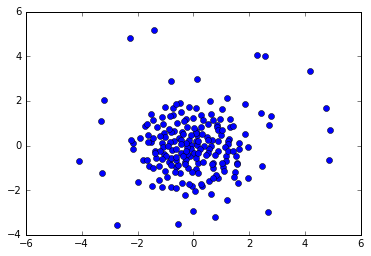

In [33]:
embedding = mds.embedding_.tolist()
x = list(map(lambda x:x[0],embedding))
y = list(map(lambda x:x[1],embedding))
plt.plot(x,y,'bo')
plt.show()

#### Prepare for regression :TODO

At this step, we will initialize the matricies we need to run a linear regression algorithm.
We will need to create a document term matrix, and a words by cluster matrix.
We will first use sklearn's CountVectorizer function to create the document term matrix. 
We will create the words by cluster matrix by giving each word a one hot vector, with a
one in the cluster number, and a 0 everywhere else.

In [ ]:
wordDict ={}
for sentence in df["rawtext"]:
    for word in sentence.split():
        if word in wordDict.keys() and word != "[deleted]":
            wordDict[word] =1+wordDict[word]
        else:
            wordDict[word] =1

In [ ]:
df["cleantext"]=df["rawtext"].apply((lambda str : ' '.join(list(filter(lambda s: wordDict[s]>=10 ,str.split())))))

In [ ]:
countvec = CountVectorizer()

In [ ]:
PostsByWords =countvec.fit_transform(df.cleantext)

In [ ]:
PostsByWords

In [ ]:
PostsByFeatures = np.dot(PostsByWords,WordByFeatureMat)